In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgi
import pandas as pd

In [58]:
dataset_name = "email-enron"

H = xgi.load_xgi_data(dataset_name)

In [59]:
print(H)

Hypergraph named email-Enron with 148 nodes and 10885 hyperedges


In [60]:
vals, counts = np.unique(
    [len(c) for c in xgi.connected_components(H)], return_counts=True
)
pd.DataFrame({"Component Size": vals, "Number": counts})

,Component Size,Number
0,1,5
1,143,1


In [61]:
xgi.unique_edge_sizes(H)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 36, 37]

In [62]:
def plot_distributions(H, node_bins=None, edge_bins=None):

    if node_bins is None:
        node_bins = int(H.num_nodes / 20)

    if edge_bins is None:
        s = H.edges.size
        edge_bins = int(s.max() - s.min() + 1)

    plt.figure(figsize=(8, 4))
    plt.subplot(121)

    h1 = H.nodes.degree.ashist(bins=node_bins, density=True, log_binning=True)
    h2 = H.edges.size.ashist(bins=edge_bins, density=True, log_binning=True)
    y1 = h1[h1.value > 0].value
    y2 = h2[h2.value > 0].value
    ymin = 0.95 * min(y1.min(), y2.min())
    ymax = 1.05 * max(y1.max(), y2.max())

    plt.loglog(h1["bin_center"], h1["value"], "ko", markersize=2)
    plt.title("Degree distribution")
    plt.xlabel(r"$k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.ylim([ymin, ymax])
    sns.despine()

    plt.subplot(122)
    
    plt.loglog(h2["bin_center"], h2["value"], "ko", markersize=2)
    plt.title("Edge size distribution")
    plt.xlabel(r"$s$", fontsize=16)
    plt.ylabel(r"$P(s)$", fontsize=16)
    plt.ylim([ymin, ymax])
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"datasheets/{dataset_name}/stats.png", dpi=300)
    plt.show()

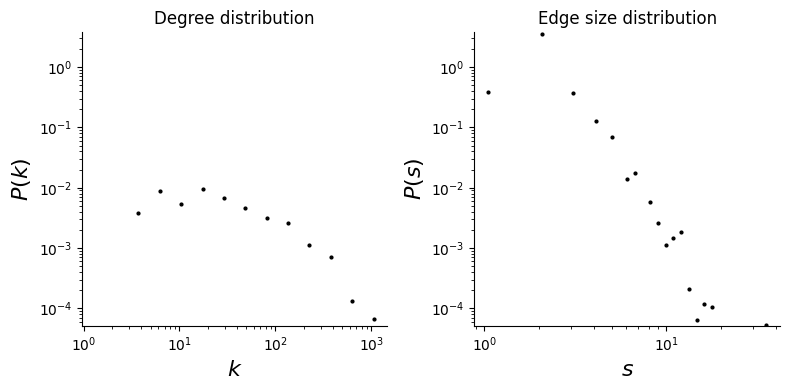

In [64]:
plot_distributions(H, node_bins=14)